# Setting up environment and importing modules

In [1]:

%load_ext autoreload
%autoreload 2
import os
import pathlib

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
#os.environ["BART_TOOLBOX_PATH"] = "/home/usr/razzaquer/Desktop/ese5934_project/ese5934_project/bart"
#"/Users/chunxuguo/bart"
import torch
import torchopt
from einops import rearrange, reduce# Array manipulation
from fastmri import complex_abs
from fastmri.data import mri_data, subsample, transforms

from ese5934_project.datasets.csm_estimation import espirit_csm_estimation
from ese5934_project.models.operators import ForwardModel, MaskedForwardModel
from ese5934_project.tasks.mri_reconstruction_2d import reconstruct


# Create a mask function

In [2]:

mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[1])




# The `data_transform` function takes raw MRI data (`kspace`, `mask`) as input, applies normalization and undersampling, 
# estimates coil sensitivity maps, and returns the processed data in a format suitable for use in MRI reconstruction tasks.

In [4]:


def data_transform(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    # kspace = kspace
    # masked_kspace = masked_kspace
    # csm = csm
    # mask = rearrange(mask, "() () w ()-> () () w")
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm




# Extracting the Data

In [5]:
dataset = mri_data.SliceDataset(
    root=pathlib.Path("/home/usr/razzaquer/Desktop/ese5934_project/Main Data"),
    transform=data_transform,
    challenge="multicoil",
)

In [6]:
# Check the data type of the dataset object

dataset_type = type(dataset)
print("Dataset Type:", dataset_type)
len(dataset)

Dataset Type: <class 'fastmri.data.mri_data.SliceDataset'>


33

In [7]:
# Access contents in the dataset

#for data in dataset:
    #print(data)  # Assuming each element of the dataset is printed


In [8]:
#Accessing all elements

first_element = dataset[0]  
print("First Element:", first_element)

tensor([[[5.0087e-05, 1.3522e-04]]]) tensor([[[0.2028, 0.2027]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.
First Element: (tensor([[[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         ...,

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]]],


        [[[0., 0.],
         

In [9]:
#Accessing any one element 

TUP1=dataset[2]
len(TUP1) #Any one element is a tuple, with 5 elements, among them 1 is a tuple, and rest 4 are tensors, among them 3 have the dimension torch.Size([15, 640, 368, 2]), and 1 has dimension ([1,1,368,1]) 

tensor([[[0.0008, 0.0007]]]) tensor([[[0.6448, 0.6412]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


5

In [11]:
# Access the tuple


# Extract each element of the tuple
element1 = TUP1[0]
element2 = TUP1[1]
element3 =TUP1[2]
element4 =TUP1[3]
element5 = TUP1[4]

# Print or use each extracted element as needed
print("Element 1:", element5)


Element 1: tensor([[[[0., -0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., -0.],
          [0., -0.],
          [0., -0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., -0.],
          [0., -0.],
          [0., 0.]],

         [[0., -0.],
          [0., -0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., -0.]],

         ...,

         [[0., -0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., -0.],
          [0., -0.],
          [0., -0.]],

         [[0., -0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., -0.],
          [0., -0.],
          [0., -0.]],

         [[0., -0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., -0.],
          [0., -0.]]],


        [[[0., -0.],
          [0., -0.],
          [0., -0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0

In [12]:
element4.shape
#len(element2)
"In MRI, k-space data with multiple coils often arises from parallel imaging techniques, where multiple receiver coils are used to acquire data simultaneously. Each coil captures a portion of the k-space data independently, allowing for faster acquisition and improved signal-to-noise ratio."

"Given that your k-space data has 15 coils, the first dimension of the tensor with size 15 likely represents each coil. Therefore, the shape `[15, 640, 368, 2]` can be interpreted as follows:"

"- 15: Number of coils."
"- 640: Number of samples along the frequency encoding direction."
"- 368: Number of samples along the phase encoding direction."
"- 2: Complex values (real and imaginary parts) for each data point."

"This shape suggests that you have k-space data acquired from 15 coils, where each coil's data is represented as a 2D array with dimensions `640 x 368` and each data point contains complex values."

"If you have any further questions or need additional clarification, please feel free to ask!"



'If you have any further questions or need additional clarification, please feel free to ask!'

In [13]:
# Reading hdF5 file in general
import h5py

# Open the HDF5 file
with h5py.File('/home/usr/razzaquer/Desktop/ese5934_project/Main Data/file1002570.h5', 'r') as f:
    # List all datasets in the file
    print("Datasets in the HDF5 file:", list(f.keys()))
    # Access a specific dataset (replace 'dataset_name' with the actual dataset name)
    dataset_name = 'kspace'
    dataset = f[dataset_name]

    # Read data from the dataset
    data = dataset[()]  # This reads the entire dataset into a NumPy array

    # Access attributes of the dataset
    attributes = dataset.attrs  # This gets all the attributes associated with the dataset

    # Print dataset shape and attributes
    print("Dataset shape:", data.shape)
    print("Dataset attributes:", attributes)



    

Datasets in the HDF5 file: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Dataset shape: (33, 15, 640, 368)
Dataset attributes: <Attributes of HDF5 object at 140032909604560>


# Grid Field (Voxel Representation)

In [14]:
dataset = mri_data.SliceDataset(
    root=pathlib.Path("/home/usr/razzaquer/Desktop/ese5934_project/Main Data"),
    transform=data_transform,
    challenge="multicoil",
)



#This code is setting up the optimization process for MRI reconstruction, initializing an optimizer, 
#retrieving relevant data from the dataset, and preparing a Grid object for further processing.


#The Grid module represents a trainable grid parameter that can be used as part of a neural network model in PyTorch. 

from ese5934_project.models.GridField import Grid

optimizer = torchopt.adam(lr=0.001)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Grid((640, 368), mean, std)

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


In [15]:
print(kspace.shape,masked_kspace.shape, mask.shape, csm.shape)

#mask.shape: This tensor has a shape of (1, 1, 368, 1).

#The first dimension (1) suggests that there is only one mask in the dataset.
#The second dimension (1) indicates that there is only one channel in the mask.
#The third dimension (368) represents the number of columns in the mask.
#The fourth dimension (1) suggests that there is only one value associated with each column in the mask

torch.Size([15, 640, 368, 2]) torch.Size([15, 640, 368, 2]) torch.Size([1, 1, 368, 1]) torch.Size([15, 640, 368, 2])


# Reconstruction: ADAM Optimizer

In [16]:
params, image_list_ADAM= reconstruct(
    field,
    torch.rand(1, 2), #tensor([[0.9300, 0.4349]])                
    masked_kspace,
    csm,
    mask,
    optimizer=optimizer,
    iterations=8000,
    device=torch.device("cpu"),
)#device=torch.device("cuda")--Try to use it for my server--x should be the inverse fourier transform of y for the initialization

iteration 1, loss: 3.1375985145568848
iteration 2, loss: 3.1370012760162354
iteration 3, loss: 3.136404037475586
iteration 4, loss: 3.1358070373535156
iteration 5, loss: 3.1352100372314453
iteration 6, loss: 3.134613513946533
iteration 7, loss: 3.134016752243042
iteration 8, loss: 3.13342022895813
iteration 9, loss: 3.1328237056732178
iteration 10, loss: 3.132227659225464
iteration 11, loss: 3.131631851196289
iteration 12, loss: 3.131035327911377
iteration 13, loss: 3.130439519882202
iteration 14, loss: 3.1298444271087646
iteration 15, loss: 3.129248857498169
iteration 16, loss: 3.1286532878875732
iteration 17, loss: 3.1280579566955566
iteration 18, loss: 3.1274631023406982
iteration 19, loss: 3.12686824798584
iteration 20, loss: 3.1262731552124023
iteration 21, loss: 3.125678300857544
iteration 22, loss: 3.125084161758423
iteration 23, loss: 3.1244895458221436
iteration 24, loss: 3.1238954067230225
iteration 25, loss: 3.1233012676239014
iteration 26, loss: 3.1227073669433594
iteration

In [17]:
type(image_list_ADAM)
len(image_list_ADAM)

160

In [18]:
# Applicable for 20 images from 200 iterations 
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 1x4
#fig, axs = plt.subplots(1, 4, figsize=(20, 10))
#for i, image in enumerate(image_list):
    #axs[i % 5].imshow(complex_abs(image), cmap="gray")

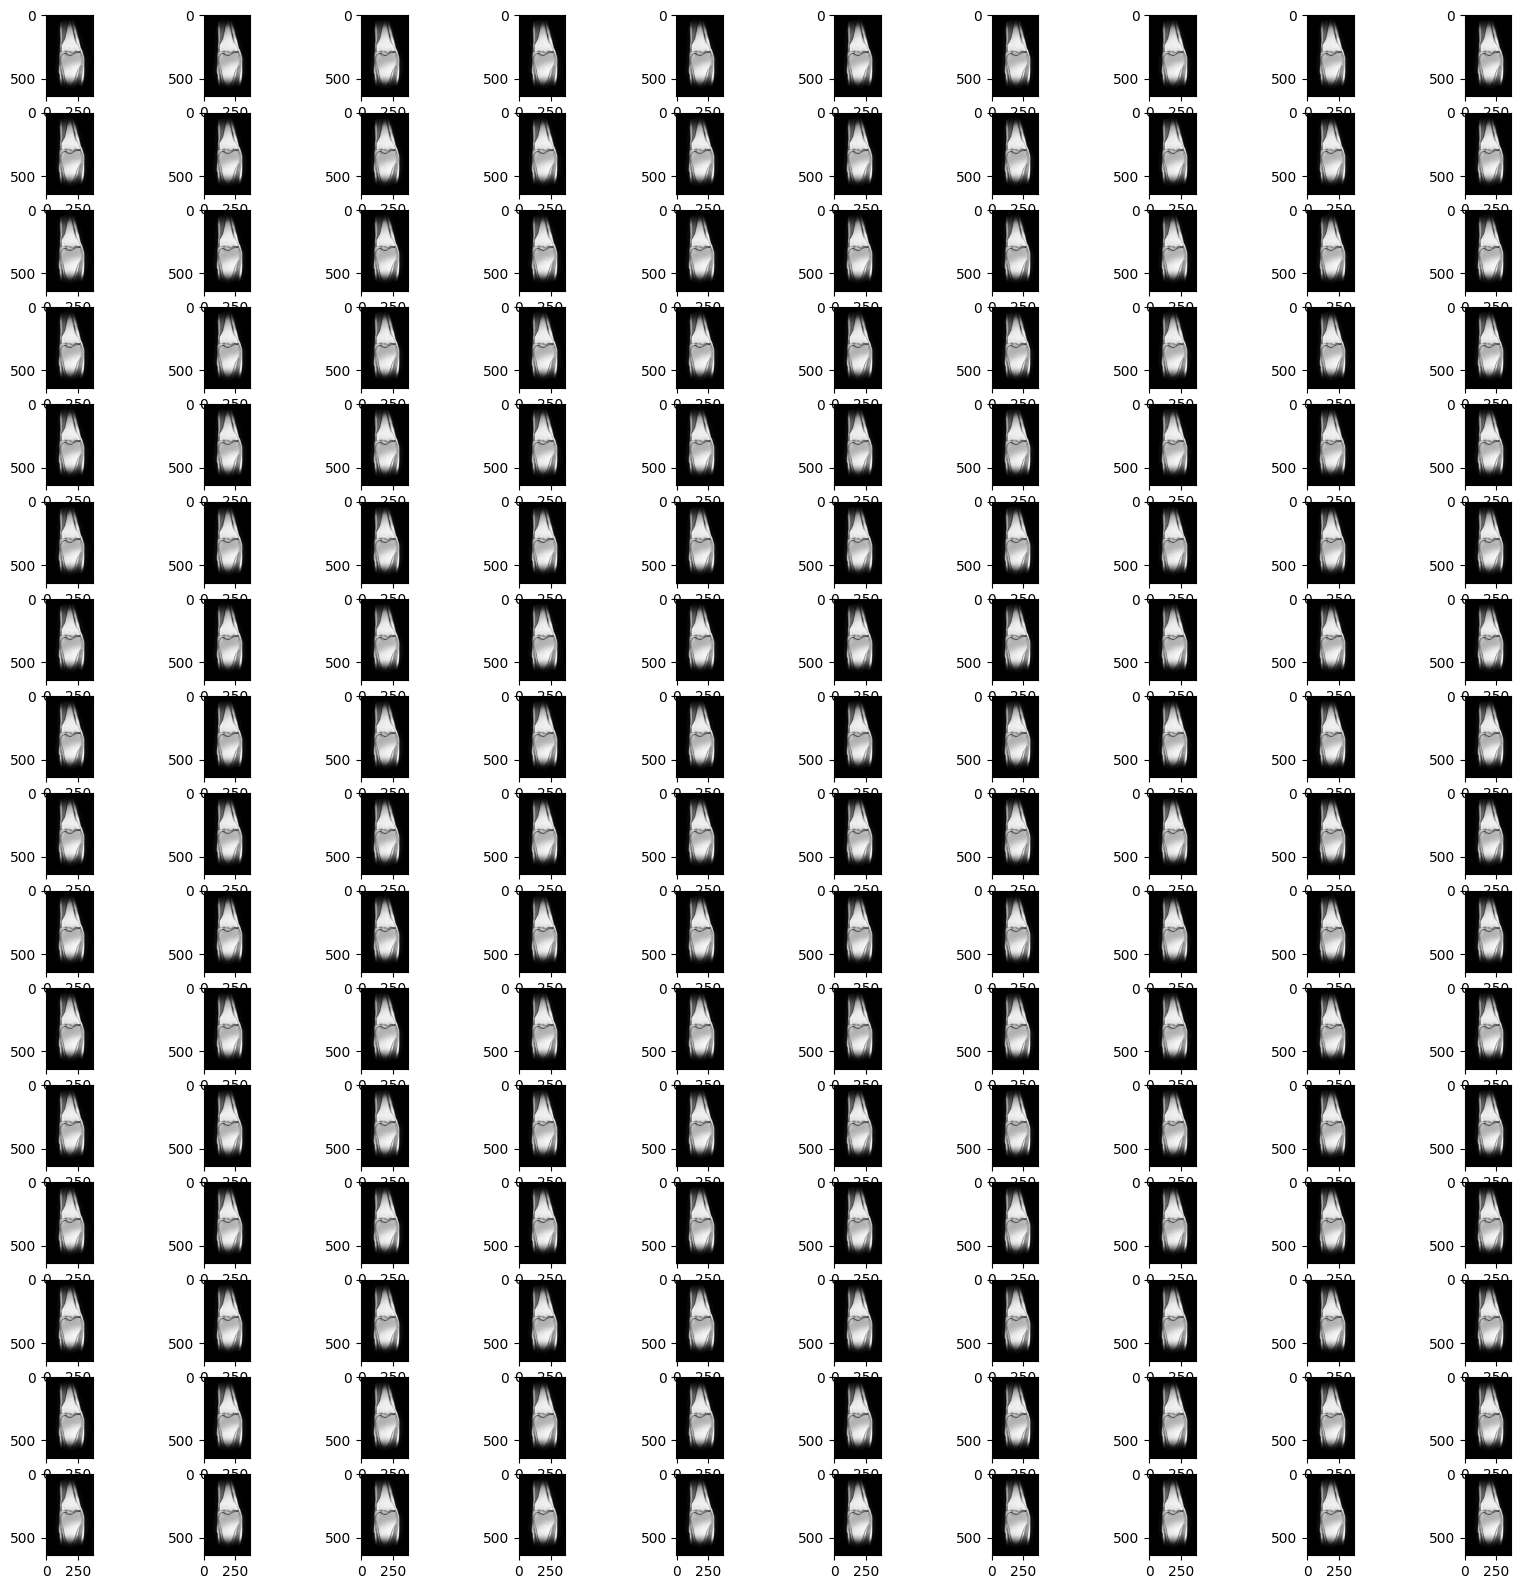

In [20]:
import matplotlib.pyplot as plt

# there are 160 images in the list,
# we want to plot them in a grid of 16x10 (20x8,replace 10 by 8, make figsize= (16,20))
fig, axs = plt.subplots(16, 10, figsize=(20, 20))
for i, image in enumerate(image_list_ADAM):
    row_idx = i // 10
    col_idx = i % 10
    axs[row_idx, col_idx].imshow(complex_abs(image), cmap="gray")
#plt.show()

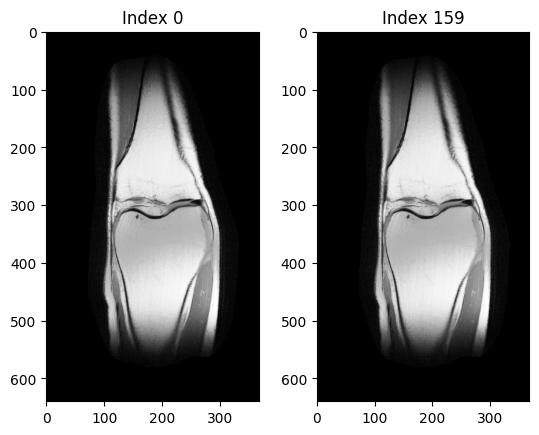

In [21]:
import matplotlib.pyplot as plt

# Plot the first figure of index 0
plt.subplot(1, 2, 1)
plt.imshow(complex_abs(image_list_ADAM[0]), cmap="gray")
plt.title("Index 0")

# Plot the last figure of index 159
plt.subplot(1, 2, 2)
plt.imshow(complex_abs(image_list_ADAM[-1]), cmap="gray")
plt.title("Index 159")

plt.show()


TypeError: Invalid shape (1, 1, 368, 1) for image data

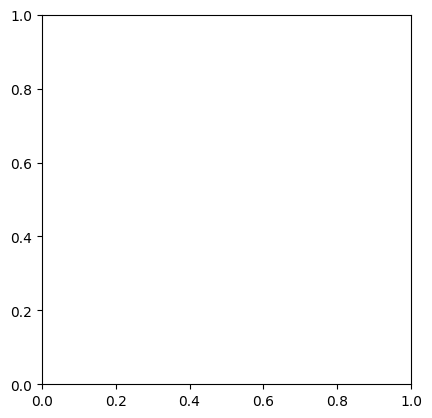

In [106]:
import matplotlib.pyplot as plt

# Plot the first figure of index 0
#plt.subplot(1, 2, 1)
plt.imshow(complex_abs(masked_kspace), cmap="gray")

plt.title("Masked  Kspace")

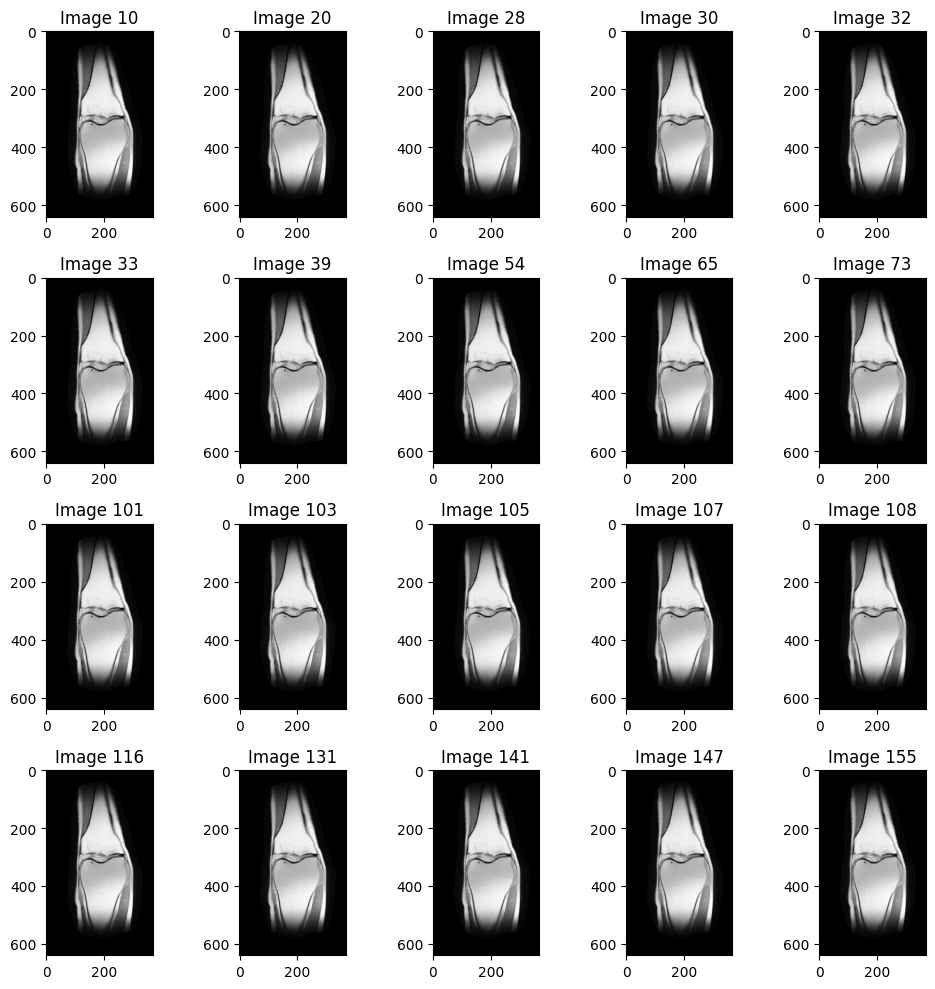

In [22]:
import random
import matplotlib.pyplot as plt

# Randomly select 20 indices from 0 to 159
random_indices =sorted(random.sample(range(160), 20))

# Plot the randomly selected images
fig, axs = plt.subplots(4, 5, figsize=(10, 10))

# Flatten the axs array to easily access each subplot
axs = axs.flatten()

# Plot each randomly selected image
for i, index in enumerate(random_indices):
    image = image_list_ADAM[index]
    axs[i].imshow(complex_abs(image), cmap="gray")
    axs[i].set_title(f"Image {index+1}")  # Set title for each subplot

# Hide any remaining empty subplots
#for j in range(20, 4 * 5):
    #axs[j].axis("off")

plt.tight_layout()
plt.show()


# SIREN

In [99]:
coords = get_coordinates(size)

In [100]:
print(coords)

tensor([[[-1.0000, -1.0000],
         [-1.0000, -0.9946],
         [-1.0000, -0.9891],
         ...,
         [-1.0000,  0.9891],
         [-1.0000,  0.9946],
         [-1.0000,  1.0000]],

        [[-0.9969, -1.0000],
         [-0.9969, -0.9946],
         [-0.9969, -0.9891],
         ...,
         [-0.9969,  0.9891],
         [-0.9969,  0.9946],
         [-0.9969,  1.0000]],

        [[-0.9937, -1.0000],
         [-0.9937, -0.9946],
         [-0.9937, -0.9891],
         ...,
         [-0.9937,  0.9891],
         [-0.9937,  0.9946],
         [-0.9937,  1.0000]],

        ...,

        [[ 0.9937, -1.0000],
         [ 0.9937, -0.9946],
         [ 0.9937, -0.9891],
         ...,
         [ 0.9937,  0.9891],
         [ 0.9937,  0.9946],
         [ 0.9937,  1.0000]],

        [[ 0.9969, -1.0000],
         [ 0.9969, -0.9946],
         [ 0.9969, -0.9891],
         ...,
         [ 0.9969,  0.9891],
         [ 0.9969,  0.9946],
         [ 0.9969,  1.0000]],

        [[ 1.0000, -1.0000],
       

In [23]:
from ese5934_project.models.SIREN import Siren, get_coordinates

device = torch.device("cpu")
size = (640, 368)
coords = get_coordinates(size)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Siren(
    size,
    mean.to(device),
    std.to(device),
    in_features=2,
    out_features=2,
    hidden_features=128,
    hidden_layers=3,
    outermost_linear=True,
)
optimizer = torchopt.adamw(lr=1e-3)
# 1e-4 1.092077389
# 1e-3 0.09540542
# 1e-2

/home/usr/razzaquer/.local/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


In [24]:
params, image_list_SIREN = reconstruct(
    field,
    coords,
    masked_kspace,
    csm,
    mask,
    optimizer=optimizer,
    iterations=1000,
    device=device,
)

iteration 1, loss: 3.1239242553710938
iteration 2, loss: 3.0730202198028564
iteration 3, loss: 3.032758951187134
iteration 4, loss: 3.085479974746704
iteration 5, loss: 2.966134548187256
iteration 6, loss: 2.954164505004883
iteration 7, loss: 2.884749412536621
iteration 8, loss: 2.848459005355835
iteration 9, loss: 2.7940521240234375
iteration 10, loss: 2.7537615299224854
iteration 11, loss: 2.6983256340026855
iteration 12, loss: 2.6506035327911377
iteration 13, loss: 2.591721296310425
iteration 14, loss: 2.5448575019836426
iteration 15, loss: 2.4863743782043457
iteration 16, loss: 2.4335122108459473
iteration 17, loss: 2.3797779083251953
iteration 18, loss: 2.326212167739868
iteration 19, loss: 2.2764477729797363
iteration 20, loss: 2.2238125801086426
iteration 21, loss: 2.175316095352173
iteration 22, loss: 2.127849578857422
iteration 23, loss: 2.080571413040161
iteration 24, loss: 2.035327672958374
iteration 25, loss: 1.9908305406570435
iteration 26, loss: 1.9488931894302368
iterati

In [25]:
len(image_list_SIREN)

20

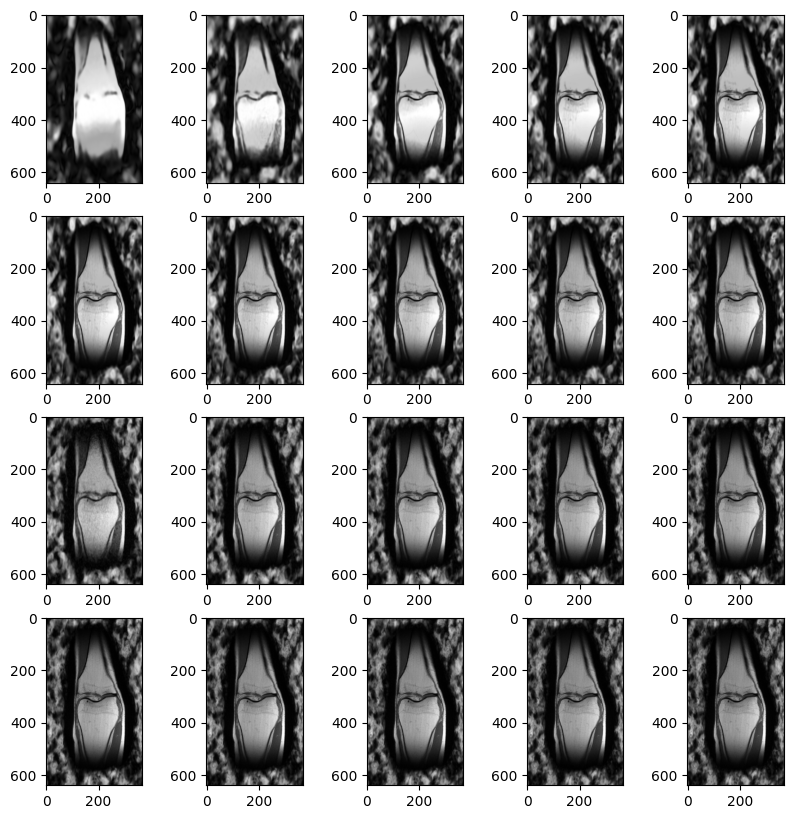

In [26]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(4, 5, figsize=(10, 10))
for i, image in enumerate(image_list_SIREN):
    axs[i // 5, i % 5].imshow(complex_abs(image), cmap="gray")

# Evaluation Metrics: PSNR + SSIM

In [30]:
import numpy as np
import math
import cv2


In [27]:
# Creating PSNR function 
# Formula Link: https://cvnote.ddlee.cc/2019/09/12/psnr-ssim-python#matlab-implementation




def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))





In [45]:
# Create SSIM Maps and SSIM functions

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [46]:
# Assuming last images are ground truth and predicted images respectively
gt_image_ADAM = image_list_ADAM[-1]
predicted_image_SIREN = image_list_SIREN[-1]

In [47]:


# gt_image_ADAM and predicted_image_SIREN are PyTorch tensors

# Convert tensors to NumPy arrays
gt_image_ADAM_np = gt_image_ADAM.cpu().detach().numpy()
predicted_image_SIREN_np = predicted_image_SIREN.cpu().detach().numpy()

# Clip and convert images to uint8
gt_image_ADAM_np = np.clip(gt_image_ADAM_np, 0, 255).astype(np.uint8)
predicted_image_SIREN_np = np.clip(predicted_image_SIREN_np, 0, 255).astype(np.uint8)

# Calculate PSNR
psnr = calculate_psnr(gt_image_ADAM_np, predicted_image_SIREN_np)
print("PSNR:", psnr)




PSNR: 43.63046044473583


In [54]:
# Calculate SSIM 9not working)
#ssim = calculate_ssim(gt_image_ADAM_np, predicted_image_SIREN_np)
#print("SSIM:", ssim)



# PSNR, SSIM, NMSE, and NMI Alternative

In [96]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_mutual_information  as nmi
#https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.structural_similarity

In [86]:
# Assuming last images are ground truth and predicted images respectively
gt_image_ADAM = image_list_ADAM[-1]
predicted_image_SIREN = image_list_SIREN[-1]

# Clip and convert images to uint8 (Not sure which conversion is correct) or the one below
#gt_image_ADAM_np = np.clip(gt_image_ADAM_np, 0, 255).astype(np.uint8)
#predicted_image_SIREN_np = np.clip(predicted_image_SIREN_np, 0, 255).astype(np.uint8)


In [98]:

# Convert tensors to numpy arrays
gt_np = gt_image_ADAM.cpu().numpy()
pred_np = predicted_image_SIREN.cpu().numpy()

# Rescale the values to [0, 255]
gt_np = ((gt_np - gt_np.min()) / (gt_np.max() - gt_np.min()) * 255).astype(np.uint8)
pred_np = ((pred_np - pred_np.min()) / (pred_np.max() - pred_np.min()) * 255).astype(np.uint8)

# Convert to grayscale if necessary
#gt_gray = np.mean(gt_np, axis=2)#I don't think it's converting the image to gray scale
#pred_gray = np.mean(pred_np, axis=2)

#By taking the mean across the color channels, this method essentially converts the color image into grayscale by preserving the luminance information. Each pixel in the resulting grayscale image represents the average intensity of the corresponding pixel in the original color image.

# Calculate PSNR
psnr_value = psnr(gt_np, pred_np, data_range=255)
#psnr_value = psnr(gt_gray, pred_gray, data_range=255)


# Calculate NRMSE
nrmse_value = nrmse(gt_np, pred_np)
#nrmse_value = nrmse(gt_gray, pred_gray)

# Calculate SSIM
ssim_value, ssim_map = ssim(gt_np, pred_np,data_range=255,channel_axis=2,full=True)
#ssim_value, ssim_map = ssim(gt_gray, pred_gray, data_range=255,full=True)


# Calculate normalized mutual information
nmi_value = nmi(gt_np, pred_np, bins=100)



print("PSNR:", psnr_value)
print("NRMSE:", nrmse_value)
print("SSIM:", ssim_value)
print("SSIM Map:", ssim_map)
print("Normalized Mutual Information:", nmi_value)


PSNR: 14.903768029108992
NRMSE: 0.35900432597629883
SSIM: 0.5946530741321179
SSIM Map: [[[0.89712864 0.89444356]
  [0.89938519 0.86892571]
  [0.87827696 0.83194198]
  ...
  [0.62320357 0.14522154]
  [0.67325055 0.17499979]
  [0.71092367 0.28364686]]

 [[0.87744193 0.88003943]
  [0.87196175 0.85028095]
  [0.84527115 0.8130474 ]
  ...
  [0.62301183 0.12775732]
  [0.67184945 0.14973165]
  [0.7084258  0.22825211]]

 [[0.84210116 0.85934861]
  [0.82606388 0.82264301]
  [0.79292064 0.78050072]
  ...
  [0.62430369 0.10827382]
  [0.67207135 0.12403985]
  [0.70650545 0.17977904]]

 ...

 [[0.90110855 0.68844671]
  [0.89572474 0.65788696]
  [0.89130822 0.68228839]
  ...
  [0.77747075 0.89932421]
  [0.85036771 0.92909305]
  [0.88408162 0.93947889]]

 [[0.91944119 0.8055253 ]
  [0.91450862 0.78076219]
  [0.9107217  0.79757776]
  ...
  [0.77352778 0.91894847]
  [0.83793701 0.9403383 ]
  [0.86696472 0.94516942]]

 [[0.92866513 0.8913813 ]
  [0.92530632 0.86922941]
  [0.92251181 0.87189507]
  ...
  [

In [82]:
num_channels = gt_np.shape[2]
#num_channels = gt_image_ADAM.shape[2]
print("Number of color channels:", num_channels)

Number of color channels: 2


# CGM Rough (Not Final)

In [ ]:
import sigpy as sp
from sigpy.alg import ConjugateGradient

# Define the A matrix (sensitivity matrix), masked k-space data (b), and initial guess (x)
A = csm  # Assuming csm is the sensitivity matrix
b = masked_kspace  # Assuming masked k-space is the observed data
x = torch.zeros_like(b)  # Initial guess (you can provide your own initial guess if available)

# Define the Conjugate Gradient reconstruction function
def reconstruct_mri(A, b, x):
    cg = ConjugateGradient(A=A, b=b, x=x, max_iter=100, tol=0)  # Create the ConjugateGradient object
    reconstructed_image = cg.run()  # Run the Conjugate Gradient algorithm
    return reconstructed_image

# Reconstruct MRI
reconstructed_image = reconstruct_mri(A, b, x)

# Show the reconstructed image (assuming it's a torch tensor)
# You may need to adjust the dimensions and format of the reconstructed image
# to be suitable for display depending on your specific data
# For example, you can convert it to a numpy array and then display it using matplotlib
import matplotlib.pyplot as plt
import numpy as np

reconstructed_image_np = reconstructed_image.numpy()  # Convert to numpy array if necessary
plt.imshow(np.abs(reconstructed_image_np), cmap='gray')  # Assuming magnitude image for display
plt.axis('off')
plt.title('Reconstructed MRI')
plt.show()
